In [68]:
import pandas as pd
from tqdm import tqdm
import os
import pickle
import cv2
from hand_tracker_3D import HandTracker
import numpy as np

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [70]:
# 基础配置
root_dir = 'D:\\jester\\'
data_dir = 'D:\\jester\\data\\'
label_fn = 'jester-v1-labels.csv'
train_fn = 'jester-v1-train.csv'
test_fn = 'jester-v1-test.csv'
valid_fn = 'jester-v1-validation.csv'

train_output_fn = 'C:\\Users\\zys98\\Desktop\\graduation\\github-repo\\sk_dd_2019\\codes\\data\\JESTER\\train_3d.pkl'
valid_output_fn = 'C:\\Users\\zys98\\Desktop\\graduation\\github-repo\\sk_dd_2019\\codes\\data\\JESTER\\valid_3d.pkl'

train_noempty_output_fn = 'C:\\Users\\zys98\\Desktop\\graduation\\github-repo\\sk_dd_2019\\codes\\data\\JESTER\\train_3d_noempty.pkl'
valid_noempty_output_fn = 'C:\\Users\\zys98\\Desktop\\graduation\\github-repo\\sk_dd_2019\\codes\\data\\JESTER\\valid_3d_noempty.pkl'

train_custom_output_fn = 'C:\\Users\\zys98\\Desktop\\graduation\\github-repo\\sk_dd_2019\\codes\\data\\JESTER\\train_3d_custom.pkl'
valid_custom_output_fn = 'C:\\Users\\zys98\\Desktop\\graduation\\github-repo\\sk_dd_2019\\codes\\data\\JESTER\\valid_3d_custom.pkl'

train_size = 1000
valid_size = 200

joint_num = 21
joint_dim = 3

In [71]:
# 模型相关初始化
palm_model_path = ".\\models\\palm_detection.tflite"
landmark_model_path = ".\\models\\hand_landmark_3d.tflite"
anchors_path = ".\\data\\anchors.csv" 
# box_shift determines 
detector = HandTracker(palm_model_path, landmark_model_path, anchors_path,
                       box_shift=0.2, box_enlarge=1.3)
hand_pres_thresh = 1e-4 # 手部landmark评分的丢弃阈值

hand tracker 3d built ok


In [72]:
# 加载动作类别
cls_csv = pd.read_csv(root_dir + label_fn, sep=';')
cls_dict = dict(zip(cls_csv.clsid, cls_csv.clsname))
cls_dict_verse = dict(zip(cls_csv.clsname, cls_csv.clsid))
# print(cls_dict[1], cls_dict_verse['Swiping Left'])

In [73]:
print(cls_dict)

{1: 'Swiping Left', 2: 'Swiping Right', 3: 'Swiping Down', 4: 'Swiping Up', 5: 'Pushing Hand Away', 6: 'Pulling Hand In', 7: 'Sliding Two Fingers Left', 8: 'Sliding Two Fingers Right', 9: 'Sliding Two Fingers Down', 10: 'Sliding Two Fingers Up', 11: 'Pushing Two Fingers Away', 12: 'Pulling Two Fingers In', 13: 'Rolling Hand Forward', 14: 'Rolling Hand Backward', 15: 'Turning Hand Clockwise', 16: 'Turning Hand Counterclockwise', 17: 'Zooming In With Full Hand', 18: 'Zooming Out With Full Hand', 19: 'Zooming In With Two Fingers', 20: 'Zooming Out With Two Fingers', 21: 'Thumb Up', 22: 'Thumb Down', 23: 'Shaking Hand', 24: 'Stop Sign', 25: 'Drumming Fingers', 26: 'No gesture', 27: 'Doing other things'}


# 多线程初始化

In [74]:
# 多线程调用detector处理图像
import threading
class DetectorThread(threading.Thread):
    def __init__(self, timage, tdetector):
        threading.Thread.__init__(self)
        self.result = None
        self.image = timage
        self.detector = tdetector
    def run(self):
        kp, box, confidence = self.detector(self.image)
        if kp is None or confidence < hand_pres_thresh:        
            # 暂时按0处理
            kp = np.zeros(joint_dim * joint_num)
        else:
            kp = kp.reshape(joint_dim * joint_num)
        self.result = kp

class MulthreadDetector():
    def __init__(self):
        self.threadNum = 2
        self.detectors = []
        for i in range(self.threadNum):
            self.detectors.append(HandTracker(palm_model_path, landmark_model_path, anchors_path,
                       box_shift=0.2, box_enlarge=1.3))
        # TODO: 创建多个detector
    def __call__(self,skeleton_list, images):
        image_count = 0
        while image_count < len(images):
            # 开启线程
            threads = []
                
            for i in range(self.threadNum):
                if image_count + i >= len(images):
                    break
                thread = DetectorThread(images[image_count + i], self.detectors[i])
                threads.append(thread)
                thread.start()
                
            # 回收线程并获取结果
            for i in range(self.threadNum):
                if image_count + i >= len(images):
                    break
                threads[i].join()
                skeleton_list[image_count + i] = threads[i].result
            image_count += self.threadNum

## 加载训练集

In [75]:
try:
    Train = pickle.load(open(train_output_fn, "rb")) # 先加载一波旧数据
except:
    Train = {}
    Train['pose'] = []
    Train['label'] = []
print(len(Train['label']))


10


In [76]:
# 加载训练集
train_data = pd.read_csv(root_dir + train_fn, sep=';')
train_dict = dict(zip(train_data.id, train_data.clsid))
multhreadDetector = MulthreadDetector()

save_count = 0

for index in tqdm(list(train_dict.items())[len(Train['label']):train_size]):
    image_path = data_dir + str(index[0])
    image_file_list = os.listdir(image_path)    
    # 逐个加载并用 HandTracker 得出骨架数据
    skeleton_list = np.empty((len(image_file_list),(joint_dim * joint_num)), dtype = float, order = 'C')
    image_list = []
    for file_index in range(len(image_file_list)):
        file = image_file_list[file_index]
        image = cv2.imread(image_path + '\\' + file)[:,:,::-1]
        image = cv2.resize(image,(256,256)) # resize 为 mediapipe 处理的格式，且实时检测也要保持这个
        image_list.append(image)
    multhreadDetector(skeleton_list, image_list)
    Train['pose'].append(skeleton_list)
    Train['label'].append(index[1])

    save_count += 1
    if save_count % 50 == 0:
        pickle.dump(Train, open(train_output_fn, "wb"))

# TODO: 空骨架 --> 开头(0,0,0)，中间插值
# TODO: 中值滤波

hand tracker 3d built ok
hand tracker 3d built ok









  0%|                                                                                          | 0/990 [00:00<?, ?it/s]






  0%|                                                                                | 1/990 [00:16<4:34:26, 16.65s/it]






  0%|▏                                                                               | 2/990 [00:30<4:10:32, 15.22s/it]






  0%|▏                                                                               | 3/990 [00:46<4:15:02, 15.50s/it]






  0%|▎                                                                               | 4/990 [00:54<3:42:33, 13.54s/it]






  1%|▍                                                                               | 5/990 [01:06<3:37:36, 13.26s/it]






  1%|▍                                                                               | 6/990 [01:16<3:28:18, 12.70s/it]






  1%|▌                                                                               | 7/990 [01:31<3:34:07, 13

  7%|█████▏                                                                         | 65/990 [14:25<3:25:14, 13.31s/it]






  7%|█████▎                                                                         | 66/990 [14:42<3:25:52, 13.37s/it]






  7%|█████▎                                                                         | 67/990 [14:57<3:25:59, 13.39s/it]






  7%|█████▍                                                                         | 68/990 [15:11<3:26:01, 13.41s/it]






  7%|█████▌                                                                         | 69/990 [15:28<3:26:36, 13.46s/it]






  7%|█████▌                                                                         | 70/990 [15:44<3:26:49, 13.49s/it]






  7%|█████▋                                                                         | 71/990 [15:59<3:27:04, 13.52s/it]






  7%|█████▋                                                                         | 72/990 [16:11<3:26:31, 13.50s/it

 13%|██████████▏                                                                   | 130/990 [29:03<3:12:16, 13.41s/it]






 13%|██████████▎                                                                   | 131/990 [29:18<3:12:11, 13.42s/it]






 13%|██████████▍                                                                   | 132/990 [29:34<3:12:14, 13.44s/it]






 13%|██████████▍                                                                   | 133/990 [29:44<3:11:40, 13.42s/it]






 14%|██████████▌                                                                   | 134/990 [30:01<3:11:45, 13.44s/it]






 14%|██████████▋                                                                   | 135/990 [30:15<3:11:39, 13.45s/it]






 14%|██████████▋                                                                   | 136/990 [30:27<3:11:18, 13.44s/it]






 14%|██████████▊                                                                   | 137/990 [30:45<3:11:28, 13.47s/it

 20%|███████████████▎                                                              | 195/990 [43:25<2:57:01, 13.36s/it]






 20%|███████████████▍                                                              | 196/990 [43:40<2:56:54, 13.37s/it]






 20%|███████████████▌                                                              | 197/990 [43:53<2:56:40, 13.37s/it]






 20%|███████████████▌                                                              | 198/990 [44:09<2:56:39, 13.38s/it]






 20%|███████████████▋                                                              | 199/990 [44:23<2:56:27, 13.38s/it]






 20%|███████████████▊                                                              | 200/990 [44:37<2:56:16, 13.39s/it]






 20%|███████████████▊                                                              | 201/990 [44:51<2:56:05, 13.39s/it]






 20%|███████████████▉                                                              | 202/990 [45:01<2:55:36, 13.37s/it

 26%|████████████████████▍                                                         | 260/990 [57:37<2:41:47, 13.30s/it]






 26%|████████████████████▌                                                         | 261/990 [57:48<2:41:26, 13.29s/it]






 26%|████████████████████▋                                                         | 262/990 [58:28<2:42:28, 13.39s/it]






 27%|████████████████████▋                                                         | 263/990 [58:39<2:42:10, 13.38s/it]






 27%|████████████████████▊                                                         | 264/990 [58:52<2:41:53, 13.38s/it]






 27%|████████████████████▉                                                         | 265/990 [59:06<2:41:43, 13.38s/it]






 27%|████████████████████▉                                                         | 266/990 [59:19<2:41:29, 13.38s/it]






 27%|█████████████████████                                                         | 267/990 [59:35<2:41:21, 13.39s/it

 33%|████████████████████████▉                                                   | 325/990 [1:13:24<2:30:11, 13.55s/it]






 33%|█████████████████████████                                                   | 326/990 [1:13:36<2:29:55, 13.55s/it]






 33%|█████████████████████████                                                   | 327/990 [1:13:47<2:29:37, 13.54s/it]






 33%|█████████████████████████▏                                                  | 328/990 [1:13:58<2:29:18, 13.53s/it]






 33%|█████████████████████████▎                                                  | 329/990 [1:14:14<2:29:10, 13.54s/it]






 33%|█████████████████████████▎                                                  | 330/990 [1:14:27<2:28:55, 13.54s/it]






 33%|█████████████████████████▍                                                  | 331/990 [1:14:41<2:28:42, 13.54s/it]






 34%|█████████████████████████▍                                                  | 332/990 [1:14:50<2:28:20, 13.53s/it

 39%|█████████████████████████████▉                                              | 390/990 [1:27:52<2:15:11, 13.52s/it]






 39%|██████████████████████████████                                              | 391/990 [1:28:08<2:15:02, 13.53s/it]






 40%|██████████████████████████████                                              | 392/990 [1:28:26<2:14:54, 13.54s/it]






 40%|██████████████████████████████▏                                             | 393/990 [1:28:40<2:14:42, 13.54s/it]






 40%|██████████████████████████████▏                                             | 394/990 [1:28:50<2:14:23, 13.53s/it]






 40%|██████████████████████████████▎                                             | 395/990 [1:29:01<2:14:06, 13.52s/it]






 40%|██████████████████████████████▍                                             | 396/990 [1:29:14<2:13:51, 13.52s/it]






 40%|██████████████████████████████▍                                             | 397/990 [1:29:28<2:13:39, 13.52s/it

 46%|██████████████████████████████████▉                                         | 455/990 [1:42:59<2:01:06, 13.58s/it]






 46%|███████████████████████████████████                                         | 456/990 [1:43:12<2:00:51, 13.58s/it]






 46%|███████████████████████████████████                                         | 457/990 [1:43:26<2:00:39, 13.58s/it]






 46%|███████████████████████████████████▏                                        | 458/990 [1:43:41<2:00:27, 13.59s/it]






 46%|███████████████████████████████████▏                                        | 459/990 [1:43:55<2:00:13, 13.58s/it]






 46%|███████████████████████████████████▎                                        | 460/990 [1:44:11<2:00:02, 13.59s/it]






 47%|███████████████████████████████████▍                                        | 461/990 [1:44:26<1:59:50, 13.59s/it]






 47%|███████████████████████████████████▍                                        | 462/990 [1:44:40<1:59:38, 13.59s/it

 53%|███████████████████████████████████████▉                                    | 520/990 [1:58:32<1:47:08, 13.68s/it]






 53%|███████████████████████████████████████▉                                    | 521/990 [1:58:45<1:46:54, 13.68s/it]






 53%|████████████████████████████████████████                                    | 522/990 [1:58:53<1:46:35, 13.66s/it]






 53%|████████████████████████████████████████▏                                   | 523/990 [1:59:10<1:46:24, 13.67s/it]






 53%|████████████████████████████████████████▏                                   | 524/990 [1:59:18<1:46:05, 13.66s/it]






 53%|████████████████████████████████████████▎                                   | 525/990 [1:59:35<1:45:55, 13.67s/it]






 53%|████████████████████████████████████████▍                                   | 526/990 [1:59:49<1:45:42, 13.67s/it]






 53%|████████████████████████████████████████▍                                   | 527/990 [2:00:06<1:45:31, 13.67s/it

 59%|████████████████████████████████████████████▉                               | 585/990 [2:13:51<1:32:40, 13.73s/it]






 59%|████████████████████████████████████████████▉                               | 586/990 [2:14:06<1:32:27, 13.73s/it]






 59%|█████████████████████████████████████████████                               | 587/990 [2:14:21<1:32:14, 13.73s/it]






 59%|█████████████████████████████████████████████▏                              | 588/990 [2:14:37<1:32:02, 13.74s/it]






 59%|█████████████████████████████████████████████▏                              | 589/990 [2:14:52<1:31:49, 13.74s/it]






 60%|█████████████████████████████████████████████▎                              | 590/990 [2:15:03<1:31:33, 13.73s/it]






 60%|█████████████████████████████████████████████▎                              | 591/990 [2:15:16<1:31:19, 13.73s/it]






 60%|█████████████████████████████████████████████▍                              | 592/990 [2:15:31<1:31:06, 13.74s/it

 66%|█████████████████████████████████████████████████▉                          | 650/990 [2:28:58<1:17:55, 13.75s/it]






 66%|█████████████████████████████████████████████████▉                          | 651/990 [2:29:12<1:17:41, 13.75s/it]






 66%|██████████████████████████████████████████████████                          | 652/990 [2:29:25<1:17:27, 13.75s/it]






 66%|██████████████████████████████████████████████████▏                         | 653/990 [2:29:39<1:17:14, 13.75s/it]






 66%|██████████████████████████████████████████████████▏                         | 654/990 [2:29:56<1:17:02, 13.76s/it]






 66%|██████████████████████████████████████████████████▎                         | 655/990 [2:30:14<1:16:50, 13.76s/it]






 66%|██████████████████████████████████████████████████▎                         | 656/990 [2:30:30<1:16:37, 13.77s/it]






 66%|██████████████████████████████████████████████████▍                         | 657/990 [2:30:47<1:16:25, 13.77s/it

 72%|██████████████████████████████████████████████████████▉                     | 715/990 [2:44:19<1:03:12, 13.79s/it]






 72%|██████████████████████████████████████████████████████▉                     | 716/990 [2:44:35<1:02:59, 13.79s/it]






 72%|███████████████████████████████████████████████████████                     | 717/990 [2:44:49<1:02:45, 13.79s/it]






 73%|███████████████████████████████████████████████████████                     | 718/990 [2:44:58<1:02:29, 13.79s/it]






 73%|███████████████████████████████████████████████████████▏                    | 719/990 [2:45:14<1:02:17, 13.79s/it]






 73%|███████████████████████████████████████████████████████▎                    | 720/990 [2:45:28<1:02:03, 13.79s/it]






 73%|███████████████████████████████████████████████████████▎                    | 721/990 [2:45:45<1:01:50, 13.79s/it]






 73%|███████████████████████████████████████████████████████▍                    | 722/990 [2:46:02<1:01:38, 13.80s/it

 79%|█████████████████████████████████████████████████████████████▍                | 780/990 [2:58:59<48:11, 13.77s/it]






 79%|█████████████████████████████████████████████████████████████▌                | 781/990 [2:59:12<47:57, 13.77s/it]






 79%|█████████████████████████████████████████████████████████████▌                | 782/990 [2:59:28<47:44, 13.77s/it]






 79%|█████████████████████████████████████████████████████████████▋                | 783/990 [2:59:40<47:30, 13.77s/it]






 79%|█████████████████████████████████████████████████████████████▊                | 784/990 [2:59:52<47:15, 13.77s/it]






 79%|█████████████████████████████████████████████████████████████▊                | 785/990 [3:00:05<47:01, 13.76s/it]






 79%|█████████████████████████████████████████████████████████████▉                | 786/990 [3:00:15<46:47, 13.76s/it]






 79%|██████████████████████████████████████████████████████████████                | 787/990 [3:00:32<46:34, 13.76s/it

 85%|██████████████████████████████████████████████████████████████████▌           | 845/990 [3:15:13<33:29, 13.86s/it]






 85%|██████████████████████████████████████████████████████████████████▋           | 846/990 [3:15:26<33:15, 13.86s/it]






 86%|██████████████████████████████████████████████████████████████████▋           | 847/990 [3:15:41<33:02, 13.86s/it]






 86%|██████████████████████████████████████████████████████████████████▊           | 848/990 [3:15:52<32:47, 13.86s/it]






 86%|██████████████████████████████████████████████████████████████████▉           | 849/990 [3:16:05<32:33, 13.86s/it]






 86%|██████████████████████████████████████████████████████████████████▉           | 850/990 [3:16:22<32:20, 13.86s/it]






 86%|███████████████████████████████████████████████████████████████████           | 851/990 [3:16:39<32:07, 13.87s/it]






 86%|███████████████████████████████████████████████████████████████████▏          | 852/990 [3:16:55<31:53, 13.87s/it

 92%|███████████████████████████████████████████████████████████████████████▋      | 910/990 [3:31:57<18:38, 13.98s/it]






 92%|███████████████████████████████████████████████████████████████████████▊      | 911/990 [3:32:14<18:24, 13.98s/it]






 92%|███████████████████████████████████████████████████████████████████████▊      | 912/990 [3:32:23<18:09, 13.97s/it]






 92%|███████████████████████████████████████████████████████████████████████▉      | 913/990 [3:32:43<17:56, 13.98s/it]






 92%|████████████████████████████████████████████████████████████████████████      | 914/990 [3:32:53<17:42, 13.98s/it]






 92%|████████████████████████████████████████████████████████████████████████      | 915/990 [3:33:06<17:28, 13.97s/it]






 93%|████████████████████████████████████████████████████████████████████████▏     | 916/990 [3:33:16<17:13, 13.97s/it]






 93%|████████████████████████████████████████████████████████████████████████▏     | 917/990 [3:33:35<17:00, 13.98s/it

 98%|████████████████████████████████████████████████████████████████████████████▊ | 975/990 [3:48:01<03:30, 14.03s/it]






 99%|████████████████████████████████████████████████████████████████████████████▉ | 976/990 [3:48:10<03:16, 14.03s/it]






 99%|████████████████████████████████████████████████████████████████████████████▉ | 977/990 [3:48:25<03:02, 14.03s/it]






 99%|█████████████████████████████████████████████████████████████████████████████ | 978/990 [3:48:45<02:48, 14.03s/it]






 99%|█████████████████████████████████████████████████████████████████████████████▏| 979/990 [3:49:00<02:34, 14.04s/it]






 99%|█████████████████████████████████████████████████████████████████████████████▏| 980/990 [3:49:11<02:20, 14.03s/it]






 99%|█████████████████████████████████████████████████████████████████████████████▎| 981/990 [3:49:30<02:06, 14.04s/it]






 99%|█████████████████████████████████████████████████████████████████████████████▎| 982/990 [3:49:49<01:52, 14.04s/it

In [77]:
# Train数据保存到pickle文件
print('已保存训练数据:', len(Train['label']))
pickle.dump(Train, open(train_output_fn, "wb"))

已保存训练数据: 1000


## 加载验证集

In [78]:
try:
    Valid = pickle.load(open(valid_output_fn, "rb")) # 先加载一波旧数据
except:
    Valid = {}
    Valid['pose'] = []
    Valid['label'] = []
print(len(Valid['label']))

2


In [79]:
# 加载验证集

valid_data = pd.read_csv(root_dir + valid_fn, sep=';')
valid_dict = dict(zip(valid_data.id, valid_data.clsid))

save_count = 0

for index in tqdm(list(valid_dict.items())[len(Valid['label']):valid_size]):
    image_path = data_dir + str(index[0])
    image_file_list = os.listdir(image_path)    
    # 逐个加载并用 HandTracker 得出骨架数据
    skeleton_list = np.empty((len(image_file_list),(joint_dim * joint_num)), dtype = float, order = 'C')
    image_list = []
    for file_index in range(len(image_file_list)):
        file = image_file_list[file_index]
        image = cv2.imread(image_path + '\\' + file)[:,:,::-1]
        image = cv2.resize(image,(256,256)) # resize 为 mediapipe 处理的格式，且实时检测也要保持这个
        image_list.append(image)
    multhreadDetector(skeleton_list, image_list)
    Valid['pose'].append(skeleton_list)
    Valid['label'].append(index[1])
    
    save_count += 1
    if save_count % 50 == 0:
        pickle.dump(Valid, open(valid_output_fn, "wb"))

# TODO: 空骨架 --> 开头(0,0,0)，中间插值
# TODO: 中值滤波








  0%|                                                                                          | 0/198 [00:00<?, ?it/s]






  1%|▍                                                                                 | 1/198 [00:14<48:47, 14.86s/it]






  1%|▊                                                                                 | 2/198 [00:32<52:48, 16.16s/it]






  2%|█▏                                                                                | 3/198 [00:47<51:11, 15.75s/it]






  2%|█▋                                                                                | 4/198 [01:06<54:09, 16.75s/it]






  3%|██                                                                                | 5/198 [01:27<56:01, 17.42s/it]






  3%|██▍                                                                               | 6/198 [01:46<56:47, 17.75s/it]






  4%|██▉                                                                               | 7/198 [01:58<53:41, 16

 33%|██████████████████████████▌                                                      | 65/198 [17:23<35:34, 16.05s/it]






 33%|███████████████████████████                                                      | 66/198 [17:41<35:22, 16.08s/it]






 34%|███████████████████████████▍                                                     | 67/198 [17:58<35:09, 16.10s/it]






 34%|███████████████████████████▊                                                     | 68/198 [18:16<34:56, 16.13s/it]






 35%|████████████████████████████▏                                                    | 69/198 [18:27<34:31, 16.06s/it]






 35%|████████████████████████████▋                                                    | 70/198 [18:46<34:20, 16.09s/it]






 36%|█████████████████████████████                                                    | 71/198 [18:57<33:54, 16.02s/it]






 36%|█████████████████████████████▍                                                   | 72/198 [19:14<33:41, 16.04s/it

 66%|████████████████████████████████████████████████████▌                           | 130/198 [33:22<17:27, 15.40s/it]






 66%|████████████████████████████████████████████████████▉                           | 131/198 [33:40<17:13, 15.42s/it]






 67%|█████████████████████████████████████████████████████▎                          | 132/198 [33:59<16:59, 15.45s/it]






 67%|█████████████████████████████████████████████████████▋                          | 133/198 [34:13<16:43, 15.44s/it]






 68%|██████████████████████████████████████████████████████▏                         | 134/198 [34:27<16:27, 15.43s/it]






 68%|██████████████████████████████████████████████████████▌                         | 135/198 [34:42<16:11, 15.43s/it]






 69%|██████████████████████████████████████████████████████▉                         | 136/198 [34:59<15:57, 15.44s/it]






 69%|███████████████████████████████████████████████████████▎                        | 137/198 [35:16<15:42, 15.45s/it

 98%|██████████████████████████████████████████████████████████████████████████████▊ | 195/198 [49:25<00:45, 15.21s/it]






 99%|███████████████████████████████████████████████████████████████████████████████▏| 196/198 [49:39<00:30, 15.20s/it]






 99%|███████████████████████████████████████████████████████████████████████████████▌| 197/198 [49:56<00:15, 15.21s/it]






100%|████████████████████████████████████████████████████████████████████████████████| 198/198 [50:13<00:00, 15.22s/it]








In [81]:
# Valid数据保存到pickle文件
print('已保存验证数据:', len(Valid['label']))
pickle.dump(Valid, open(valid_output_fn, "wb"))

已保存验证数据: 200


## 删除空frame的数据

In [82]:
# 训练集
Train_NoEmpty = pickle.load(open(train_output_fn, "rb")) # 先加载一波旧数据
poses = Train_NoEmpty['pose']

for pose_index in tqdm(range(len(poses))):
    frame_index = 0
    while frame_index < len(poses[pose_index]):
        if poses[pose_index][frame_index][0] == 0:
            poses[pose_index] = np.delete(poses[pose_index], frame_index, axis=0)
        else:
            frame_index += 1
    if len(poses[pose_index]) == 0:
        poses[pose_index] = np.zeros((1,joint_num*joint_dim))
    pose = np.zeros((1,joint_num*joint_dim))
    
print('已保存(无空帧)训练数据:', len(Train_NoEmpty['label']))
pickle.dump(Train_NoEmpty, open(train_noempty_output_fn, "wb"))








  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]






 12%|█████████▍                                                                   | 123/1000 [00:00<00:00, 1197.38it/s]






 26%|████████████████████▏                                                        | 262/1000 [00:00<00:00, 1227.58it/s]






 43%|█████████████████████████████████                                            | 429/1000 [00:00<00:00, 1369.90it/s]






 61%|███████████████████████████████████████████████                              | 612/1000 [00:00<00:00, 1478.65it/s]






 80%|█████████████████████████████████████████████████████████████▏               | 795/1000 [00:00<00:00, 1544.82it/s]






 93%|███████████████████████████████████████████████████████████████████████▉     | 934/1000 [00:00<00:00, 1515.37it/s]






100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1516

已保存(无空帧)训练数据: 1000


In [83]:
# 验证集
Valid_NoEmpty = pickle.load(open(valid_output_fn, "rb")) # 先加载一波旧数据
poses = Valid_NoEmpty['pose']

for pose_index in tqdm(range(len(poses))):
    frame_index = 0
    while frame_index < len(poses[pose_index]):
        if poses[pose_index][frame_index][0] == 0:
            poses[pose_index] = np.delete(poses[pose_index], frame_index, axis=0)
        else:
            frame_index += 1
    if len(poses[pose_index]) == 0:
        poses[pose_index] = np.zeros((1,joint_num*joint_dim))
    pose = np.zeros((1,joint_num*joint_dim))
    
print('已保存(无空帧)验证数据:', len(Valid_NoEmpty['label']))
pickle.dump(Valid_NoEmpty, open(valid_noempty_output_fn, "wb"))








  0%|                                                                                          | 0/200 [00:00<?, ?it/s]






 60%|███████████████████████████████████████████████▏                              | 121/200 [00:00<00:00, 1166.59it/s]






100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1078.15it/s]

已保存(无空帧)验证数据: 200


## 分类数 [1, N]；非空帧数 [K, ) 的数据

In [92]:
thresh_frame_num = 10 # 非空帧数 (0即所有)
thresh_frame_rate = 0.3 # 非空帧占比 (0即所有)
max_cls = 25 # class最大数

count = 0
for i in range(len(Train_NoEmpty['pose'])):
    data = Train_NoEmpty['pose'][i]
    odata = Train['pose'][i]
#     print(i,data.shape[0])
    if data.shape[0]/odata.shape[0] >= thresh_frame_rate:
        count += 1

print('非空阈值样本占比', count/len(Train_NoEmpty['pose']))


# 训练集
Train_GT20_1to6 = pickle.load(open(train_noempty_output_fn, "rb")) # 先加载一波旧数据
poses = Train_GT20_1to6['pose']
oposes = Train['pose']
labels = Train_GT20_1to6['label']
pose_index=0

while pose_index < len(labels):
    if labels[pose_index] <= max_cls and poses[pose_index].shape[0] >= thresh_frame_num and poses[pose_index].shape[0]/oposes[pose_index].shape[0] >= thresh_frame_rate:
        pose_index += 1
    else:
        poses.pop(pose_index)
        labels.pop(pose_index)
    
print('已保存(1-'+str(max_cls)+' class 非空帧数 > '+str(thresh_frame_num)+' 的数据)训练数据:', len(Train_GT20_1to6['label']))
pickle.dump(Train_GT20_1to6, open(train_custom_output_fn, "wb"))

# 验证集
Valid_GT20_1to6 = pickle.load(open(valid_noempty_output_fn, "rb")) # 先加载一波旧数据
poses = Valid_GT20_1to6['pose']
oposes = Valid['pose']
labels = Valid_GT20_1to6['label']
pose_index=0

while pose_index < len(labels):
    if labels[pose_index] <= max_cls and poses[pose_index].shape[0] >= thresh_frame_num  and poses[pose_index].shape[0]/oposes[pose_index].shape[0] >= thresh_frame_rate:
        pose_index += 1
    else:
        poses.pop(pose_index)
        labels.pop(pose_index)
    
print('已保存(1-'+str(max_cls)+' class 非空帧数 > '+str(thresh_frame_num)+' 的数据)验证数据:', len(Valid_GT20_1to6['label']))
pickle.dump(Valid_GT20_1to6, open(valid_custom_output_fn, "wb"))

非空阈值样本占比 0.542
已保存(1-25 class 非空帧数 > 10 的数据)训练数据: 490
已保存(1-25 class 非空帧数 > 10 的数据)验证数据: 94


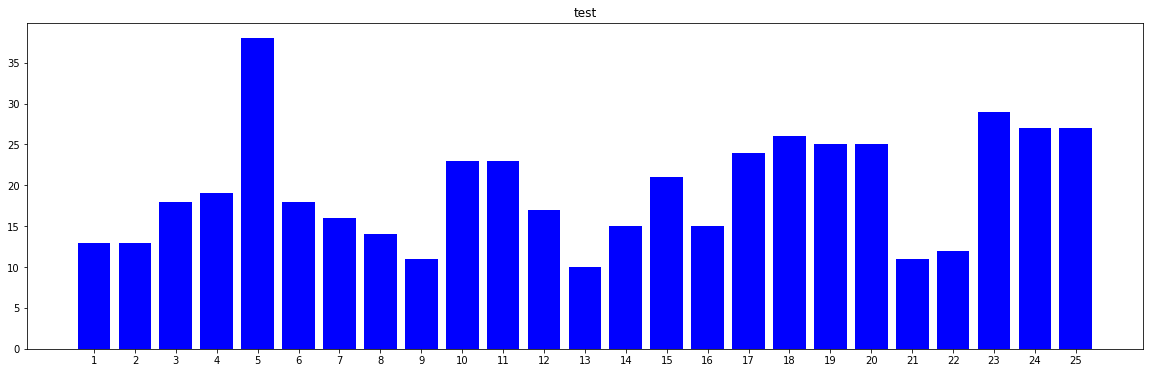

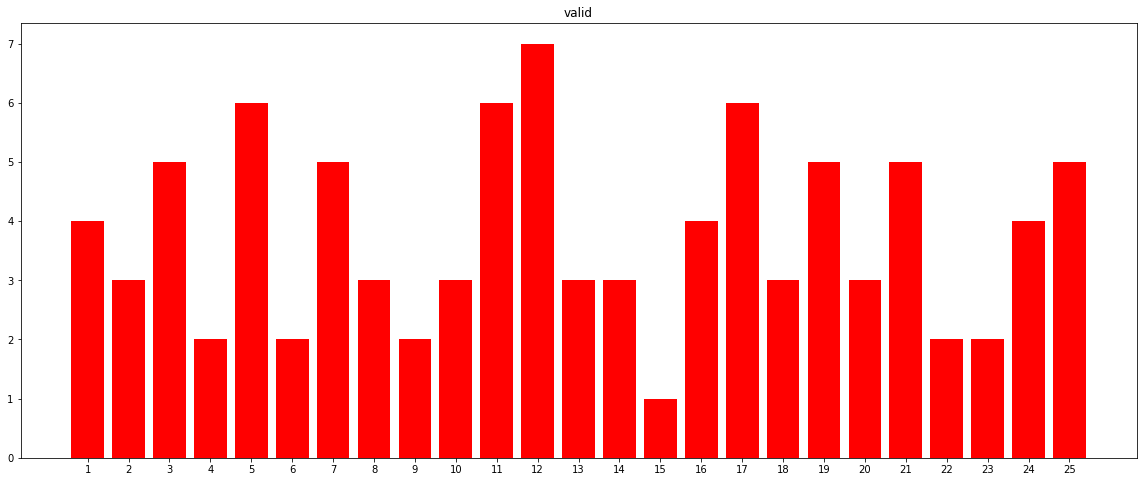

In [93]:
# 折线图显示数据分布

import matplotlib.pyplot as plt
import numpy as np  

fig_test = dict(zip(range(1,max_cls+1),(0 for _ in range(max_cls))))
fig_valid = dict(zip(range(1,max_cls+1),(0 for _ in range(max_cls))))
for i in Train_GT20_1to6['label']:
    fig_test[i] += 1
for i in Valid_GT20_1to6['label']:
    fig_valid[i] += 1

plt.figure(figsize=(20, 6))
keys=fig_test.keys()
y=fig_test.values()
x=range(len(keys))

plt.bar(x,y,color='blue')
plt.xticks(x, keys)
plt.title("test")
plt.show()

plt.figure(figsize=(20, 8))
keys=fig_valid.keys()
y=fig_valid.values()
x=range(len(keys))

plt.bar(x,y,color='red')
plt.xticks(x, keys)
plt.title("valid")
plt.show()

In [ ]:
# 平衡数据

# 训练集
ly = list(fig_test.values())
ly.sort()
minV = ly[int(len(ly)/2)]
stayPos = []
for i in fig_test.values():
    if i != 0:
        stayPos.append(minV/i)
    else:
        stayPos.append(0)
print(stayPos)
poses = Train_GT20_1to6['pose']
labels = Train_GT20_1to6['label']

import random
random.seed(20)
pose_index = 0
while pose_index < len(labels):
    if random.random() < stayPos[labels[pose_index]-1]:
        pose_index += 1
    else:
        poses.pop(pose_index)
        labels.pop(pose_index)
        
# 验证集

ly = list(fig_valid.values())
ly.sort()
minV = ly[int(len(ly)/2)]
stayPos = []
for i in fig_valid.values():
    if i != 0:
        stayPos.append(minV/i)
    else:
        stayPos.append(0)
print(stayPos)
poses = Valid_GT20_1to6['pose']
labels = Valid_GT20_1to6['label']

pose_index = 0
while pose_index < len(labels):
    if random.random() < stayPos[labels[pose_index]-1]:
        pose_index += 1
    else:
        poses.pop(pose_index)
        labels.pop(pose_index)

# 保存数据
print('已保存平衡后的训练数据:', len(Train_GT20_1to6['label']))
pickle.dump(Train_GT20_1to6, open(rootdir + train_gt20_1to6_fn, "wb"))
    
print('已保存平衡后的验证数据:', len(Valid_GT20_1to6['label']))
pickle.dump(Valid_GT20_1to6, open(rootdir + valid_gt20_1to6_fn, "wb"))

In [ ]:
# 折线图显示数据分布

fig_test = dict(zip(range(1,max_cls+1),(0 for _ in range(max_cls))))
fig_valid = dict(zip(range(1,max_cls+1),(0 for _ in range(max_cls))))
for i in Train_GT20_1to6['label']:
    fig_test[i] += 1
for i in Valid_GT20_1to6['label']:
    fig_valid[i] += 1

plt.figure(figsize=(20, 8))
keys=fig_test.keys()
y=fig_test.values()
x=range(len(keys))

plt.bar(x,y,color='blue')
plt.xticks(x, keys)
plt.title("test")
plt.show()

plt.figure(figsize=(20, 8))
keys=fig_valid.keys()
y=fig_valid.values()
x=range(len(keys))

plt.bar(x,y,color='red')
plt.xticks(x, keys)
plt.title("valid")
plt.show()

## 用于统计各数据集空骨架的概率

In [64]:
frame_count = 0
empty_count = 0
all_emtpy = 0
start = -10
end = -1
for pose in Train['pose'][start:end]:
    this_frame = 0
    this_empty = 0
    for frame in pose:
        this_frame += 1
        frame_count += 1
        if frame[0] == 0:
            empty_count += 1
            this_empty += 1
    if this_empty == this_frame:
        all_emtpy += 1
print('总空帧率(%):',empty_count / frame_count * 100)
print('空样本率(%)',all_emtpy / len(Train['pose'][start:end]) * 100)

总空帧率(%): 58.46153846153847
空样本率(%) 0.0
